In [1]:
import cPickle
from PIL import Image
import os
import sys
import numpy as np
from matplotlib.pyplot import imshow
import tensorflow as tf


data_folder = 'cifar-10-batches-py'
print os.listdir(data_folder)

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [2]:
train_batch_1 = os.path.join(data_folder, 'data_batch_1')
train_batch_2 = os.path.join(data_folder, 'data_batch_2')
train_batch_3 = os.path.join(data_folder, 'data_batch_3')
train_batch_4 = os.path.join(data_folder, 'data_batch_4')
train_batch_5 = os.path.join(data_folder, 'data_batch_5')
test_batch = os.path.join(data_folder, 'test_batch')

In [3]:
def read_batch(filename):
    with open(filename, 'r') as f:
        data = cPickle.load(f)
    return data

In [4]:
d1 = read_batch(train_batch_1)
print type(d1)
print d1.keys()
data1 = d1['data']
labels1 = d1['labels']
batch_label1 = d1['batch_label']
filenames1 = d1['filenames']
print type(data1), type(labels1), type(batch_label1), type(filenames1)

print data1.shape
print len(labels1)
print batch_label1
print len(filenames1)

print data1[0:3]
print labels1[0:3]
print filenames1[0:3]

<type 'dict'>
['data', 'labels', 'batch_label', 'filenames']
<type 'numpy.ndarray'> <type 'list'> <type 'str'> <type 'list'>
(10000, 3072)
10000
training batch 1 of 5
10000
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]]
[6, 9, 9]
['leptodactylus_pentadactylus_s_000004.png', 'camion_s_000148.png', 'tipper_truck_s_001250.png']


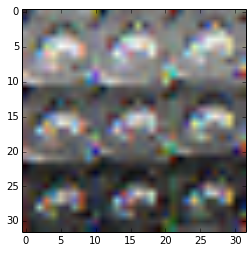

In [5]:
%matplotlib inline
example_image_np = data1[0]
example_image_np = example_image_np.reshape((32, 32, 3))
imshow(example_image_np)

(32, 32, 3)
(32, 32)


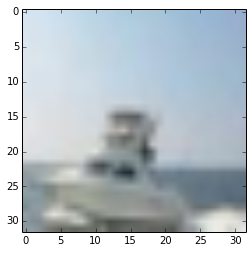

In [6]:
%matplotlib inline
example_image_np = data1[100]
example_image_np = example_image_np.reshape((3, 32, 32))
example_image_np = np.swapaxes(example_image_np, 0, 2)
example_image_np = np.swapaxes(example_image_np, 0, 1)
print example_image_np.shape
imshow(example_image_np)
example_image = Image.fromarray(example_image_np)
print example_image.size

In [7]:
train_filenames = [train_batch_1, train_batch_2, train_batch_3, train_batch_4, train_batch_5]
train_data_arr = []
train_labels_arr = []
for filename in train_filenames:
    d = read_batch(filename)
    data = d['data']
    labels = d['labels']
    train_data_arr.append(data)
    train_labels_arr.append(np.asarray(labels, dtype=np.int32))
train_data = np.vstack(train_data_arr)
train_labels = np.hstack(train_labels_arr)
print train_data.shape
print train_labels.shape

test_d = read_batch(test_batch)
test_data = test_d['data']
test_labels = np.asarray(test_d['labels'], dtype=np.int32)
print test_data.shape
print test_labels.shape

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [8]:
def generate_tf_records(data, labels, output_dir, filename_prefix = 'tfrecord', num_in_each_file = 1000):
    assert len(data) == len(labels)
    num_examples = data.shape[0]
    num_tfrecord_files = num_examples / num_in_each_file
    assert num_examples % num_in_each_file == 0
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    data = data.reshape((num_examples, 3, 32, 32))
    data = np.swapaxes(data, 1, 3)
    data = np.swapaxes(data, 1, 2)
    
    for i in range(num_tfrecord_files):
        output_tfrecord_filename = os.path.join(output_dir, '%s-%d' % (filename_prefix, i))
        tf.logging.info("generating %s" % output_tfrecord_filename)
        writer = tf.python_io.TFRecordWriter(output_tfrecord_filename)
        start_index = i * num_in_each_file
        end_index = (i + 1) * num_in_each_file
        for j in range(start_index, end_index):
            img_np = data[j]
            label = labels[j]
            img = Image.fromarray(img_np)
            img_raw = img.tobytes()
            example = tf.train.Example(features=tf.train.Features(feature={
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                "img_raw": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
            }))
            writer.write(example.SerializeToString())
        writer.close()    

In [9]:
generate_tf_records(test_data, test_labels, "test_tfrecords")
generate_tf_records(train_data, train_labels, "train_tfrecords")

INFO:tensorflow:generating test_tfrecords/tfrecord-0
INFO:tensorflow:generating test_tfrecords/tfrecord-1
INFO:tensorflow:generating test_tfrecords/tfrecord-2
INFO:tensorflow:generating test_tfrecords/tfrecord-3
INFO:tensorflow:generating test_tfrecords/tfrecord-4
INFO:tensorflow:generating test_tfrecords/tfrecord-5
INFO:tensorflow:generating test_tfrecords/tfrecord-6
INFO:tensorflow:generating test_tfrecords/tfrecord-7
INFO:tensorflow:generating test_tfrecords/tfrecord-8
INFO:tensorflow:generating test_tfrecords/tfrecord-9
INFO:tensorflow:generating train_tfrecords/tfrecord-0
INFO:tensorflow:generating train_tfrecords/tfrecord-1
INFO:tensorflow:generating train_tfrecords/tfrecord-2
INFO:tensorflow:generating train_tfrecords/tfrecord-3
INFO:tensorflow:generating train_tfrecords/tfrecord-4
INFO:tensorflow:generating train_tfrecords/tfrecord-5
INFO:tensorflow:generating train_tfrecords/tfrecord-6
INFO:tensorflow:generating train_tfrecords/tfrecord-7
INFO:tensorflow:generating train_tfrec